Using device: cpu

Loading models...
  Encoder loaded ✅
  Classifier loaded ✅

Loading data...
  Test samples: 22536

[1/6] Generating embeddings...
  Embeddings shape: (22536, 128)
  Embeddings saved ✅

[2/6] Getting predictions...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Non-Fall       0.99      0.99      0.99     18940
        Fall       0.94      0.95      0.94      3596

    accuracy                           0.98     22536
   macro avg       0.97      0.97      0.97     22536
weighted avg       0.98      0.98      0.98     22536


Per-Device Accuracy:
  SisFall: 97.38% (10753/11042)
  WISDM: 100.00% (8493/8493)
  PAMAP2: 96.13% (2885/3001)

[3/6] Creating t-SNE visualization...
Running t-SNE (this takes 2-5 minutes)...
✅ Saved: C:\Users\Amrit Shah\Desktop\protobyte 2.0\protobytes-2.0-team-Coder-Rex\docs\tsne_visualization.png

[4/6] Creating detailed t-SNE...
Running detailed t-SNE...
✅ Saved: C:\Users\Amrit Shah\Desktop\protobyte 2.0\prot

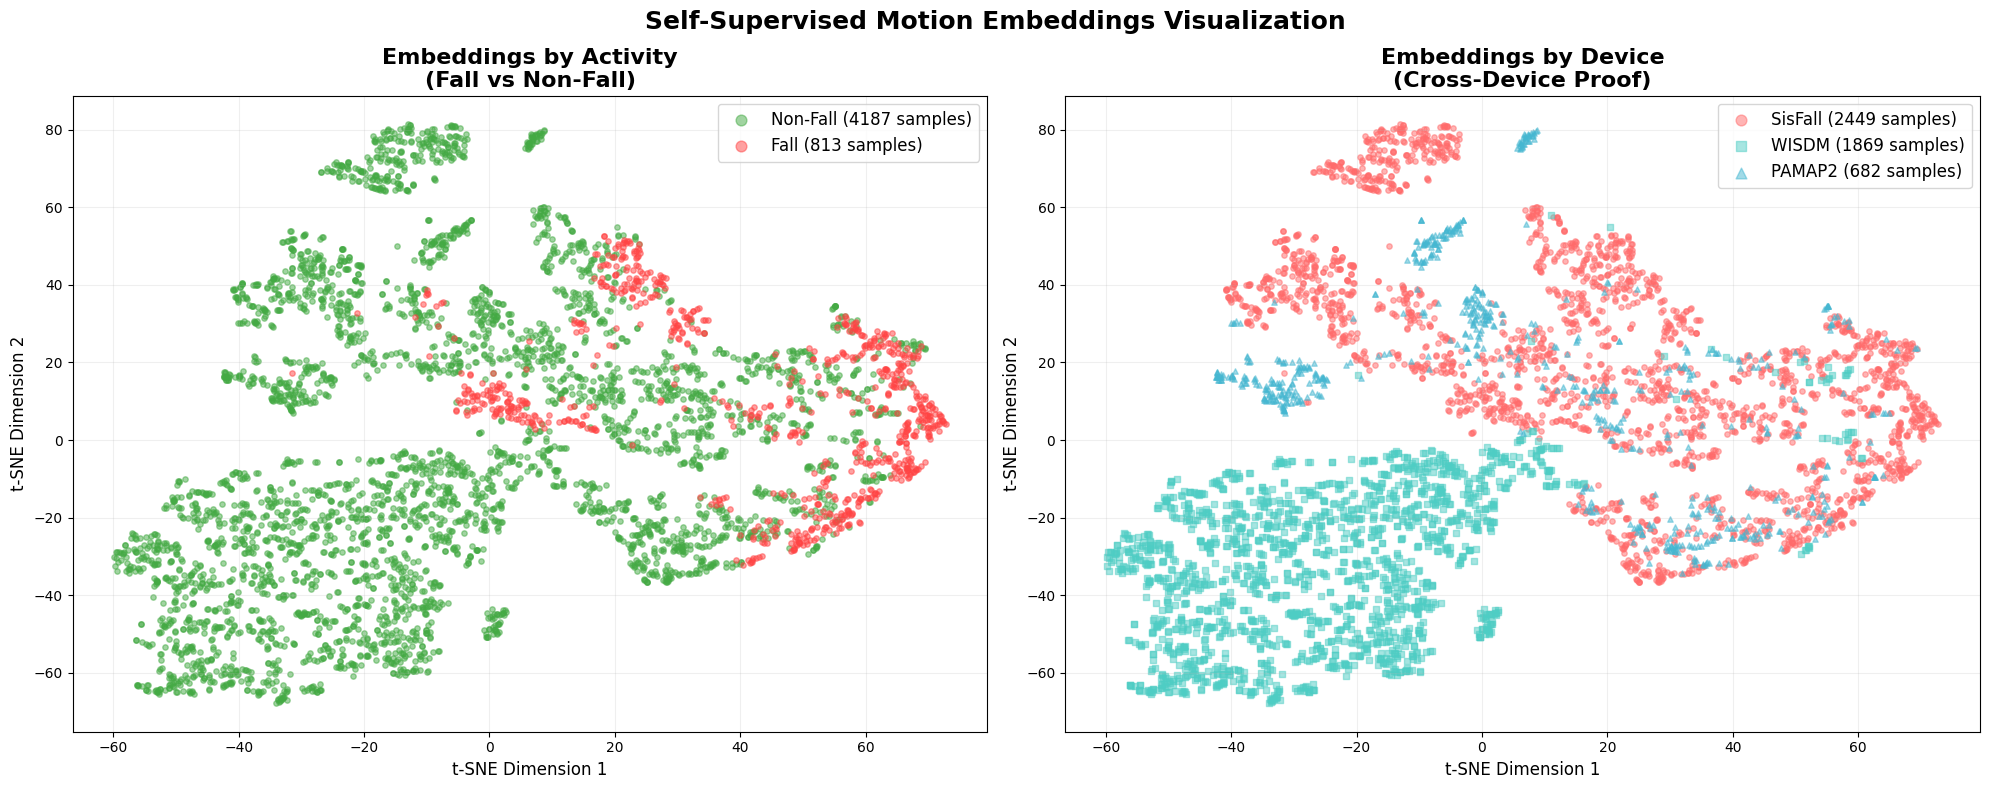

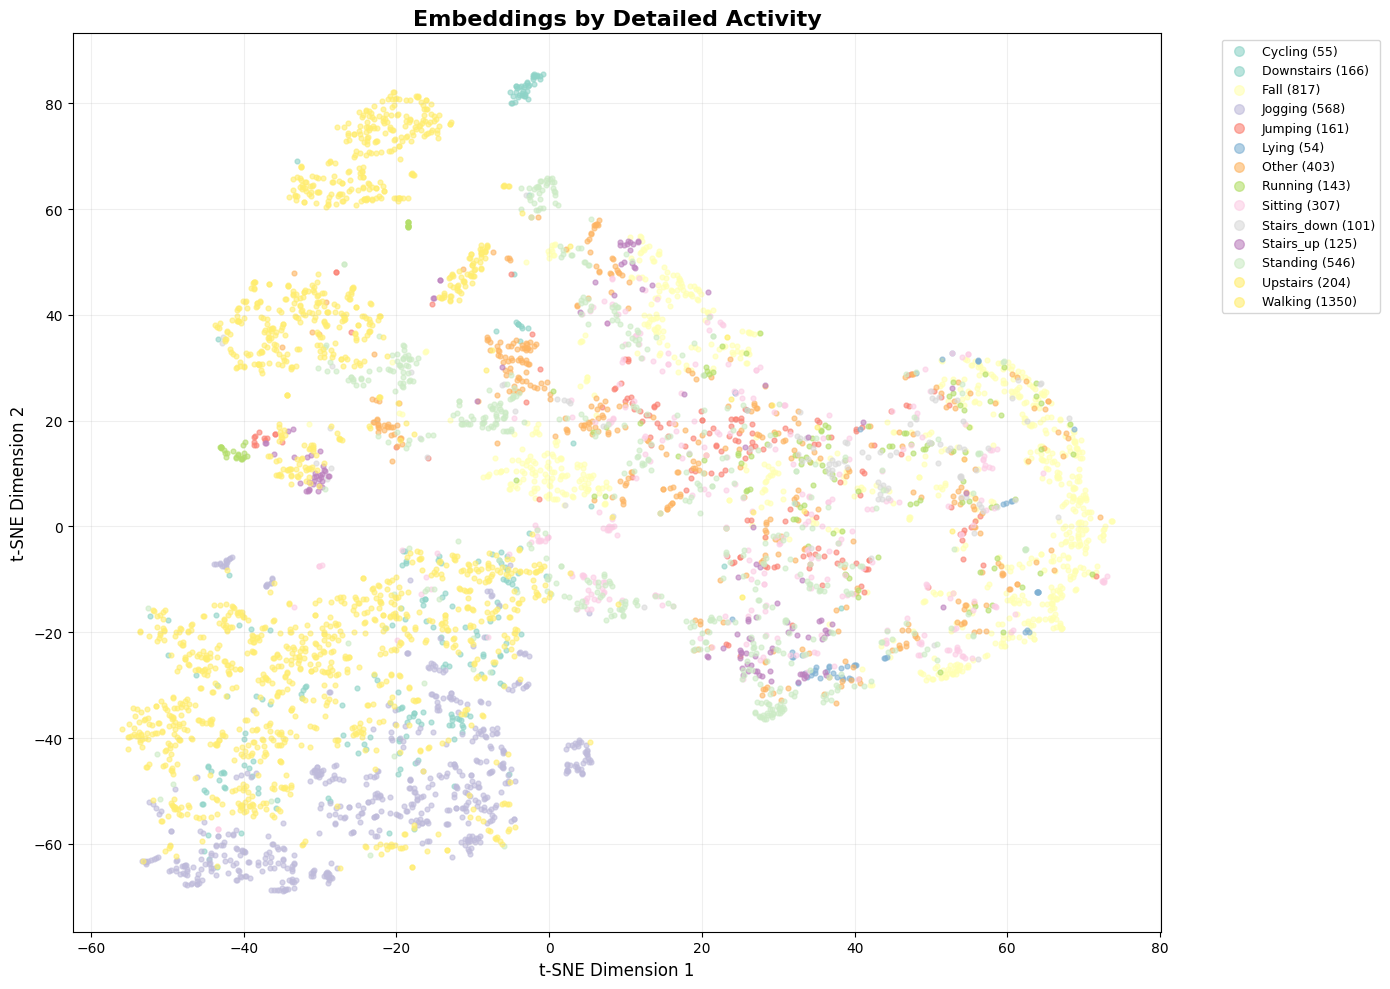

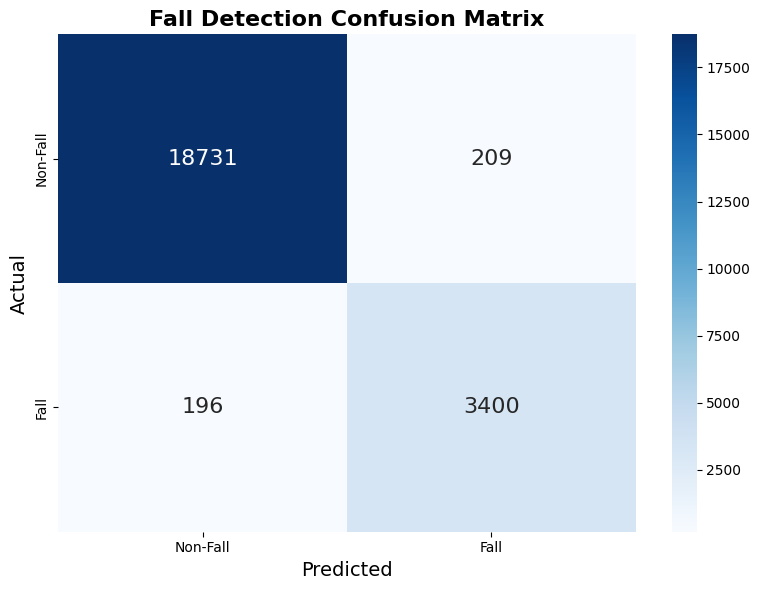

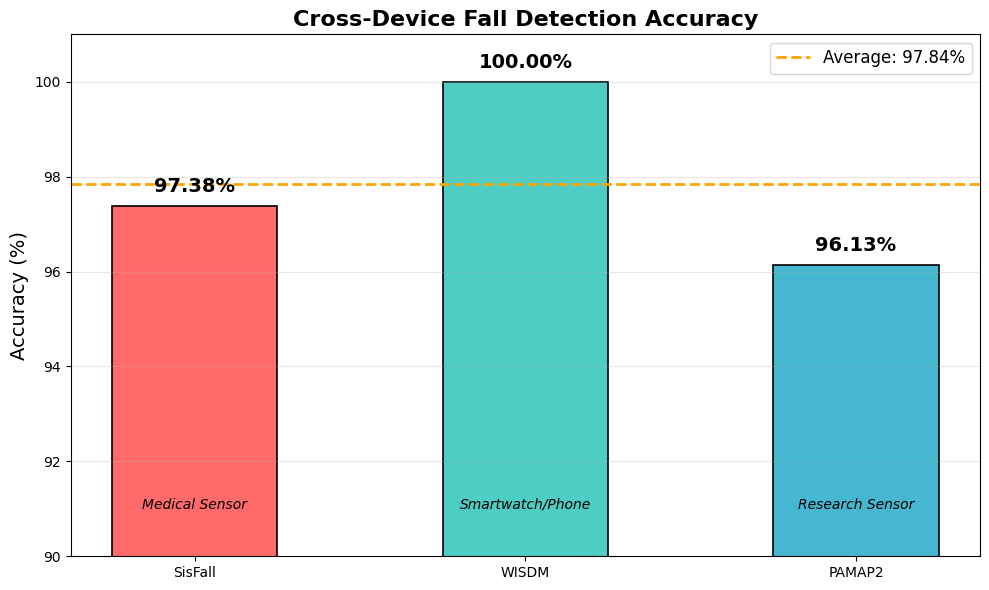

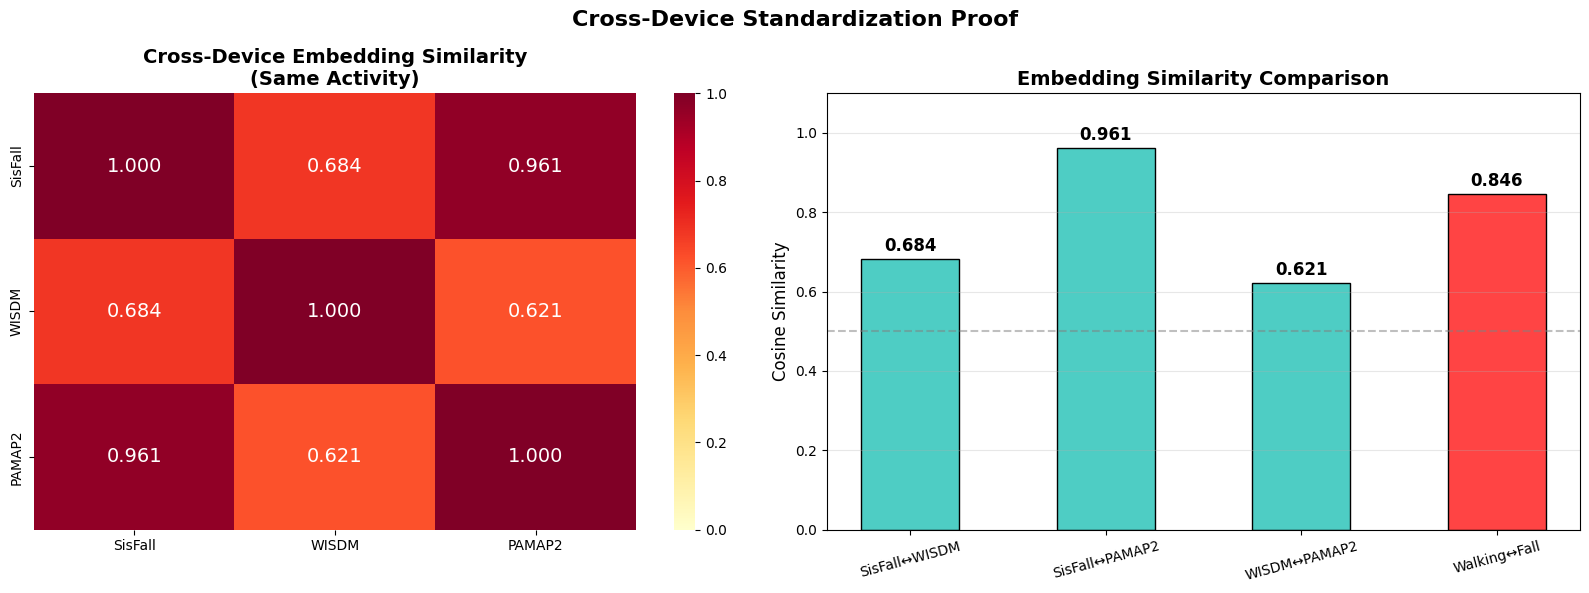

In [8]:
"""
Evaluation and Visualization
Generates all plots and metrics needed for presentation
"""

import torch
import numpy as np
import pickle
import os
import sys
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_path)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score
)
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from src.model import IMUEncoder, FallDetectionClassifier
from src.dataset import IMUDataset
from src.augmentations import create_positive_pair


def generate_embeddings(encoder, data_loader, device):
    """Generate embeddings for all data"""
    
    encoder.eval()
    all_embeddings = []
    all_labels = []
    all_sources = []
    
    with torch.no_grad():
        for data, labels, sources in data_loader:
            data = data.to(device)
            embeddings = encoder.get_embedding(data)
            
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.extend(labels)
            all_sources.extend(sources)
    
    return (
        np.vstack(all_embeddings), 
        np.array(all_labels), 
        np.array(all_sources)
    )


def plot_tsne(embeddings, labels, sources, docs_path):
    """
    Create t-SNE visualization
    THIS IS YOUR MOST IMPORTANT PLOT FOR JUDGES
    """
    
    print("Running t-SNE (this takes 2-5 minutes)...")
    
    # Use subset for faster plotting
    n_samples = min(5000, len(embeddings))
    indices = np.random.choice(len(embeddings), n_samples, replace=False)
    
    emb_subset = embeddings[indices]
    labels_subset = labels[indices]
    sources_subset = sources[indices]
    
    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    embeddings_2d = tsne.fit_transform(emb_subset)
    
    # Create figure with 2 plots
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # ---- Plot 1: Color by Activity (Fall vs Non-Fall) ----
    colors_activity = {'Fall': '#FF4444', 'Non-Fall': '#44AA44'}
    
    for label in ['Non-Fall', 'Fall']:
        mask = labels_subset == label
        axes[0].scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=colors_activity[label],
            label=f'{label} ({mask.sum()} samples)',
            alpha=0.5,
            s=15
        )
    
    axes[0].set_title('Embeddings by Activity\n(Fall vs Non-Fall)', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
    axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
    axes[0].legend(fontsize=12, markerscale=2)
    axes[0].grid(True, alpha=0.2)
    
    # ---- Plot 2: Color by Device ----
    colors_device = {
        'SisFall': '#FF6B6B',
        'WISDM': '#4ECDC4', 
        'PAMAP2': '#45B7D1'
    }
    markers_device = {
        'SisFall': 'o',
        'WISDM': 's',
        'PAMAP2': '^'
    }
    
    for source in ['SisFall', 'WISDM', 'PAMAP2']:
        mask = sources_subset == source
        axes[1].scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=colors_device[source],
            marker=markers_device[source],
            label=f'{source} ({mask.sum()} samples)',
            alpha=0.5,
            s=15
        )
    
    axes[1].set_title('Embeddings by Device\n(Cross-Device Proof)', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
    axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
    axes[1].legend(fontsize=12, markerscale=2)
    axes[1].grid(True, alpha=0.2)
    
    plt.suptitle('Self-Supervised Motion Embeddings Visualization', fontsize=18, fontweight='bold')
    plt.tight_layout()
    
    save_path = os.path.join(docs_path, "tsne_visualization.png")
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    print(f"✅ Saved: {save_path}")
    
    return embeddings_2d


def plot_tsne_detailed(embeddings, labels, sources, all_activity_labels, docs_path):
    """
    Detailed t-SNE with all activity types
    Shows clustering quality
    """
    
    print("Running detailed t-SNE...")
    
    n_samples = min(5000, len(embeddings))
    indices = np.random.choice(len(embeddings), n_samples, replace=False)
    
    emb_subset = embeddings[indices]
    activity_subset = all_activity_labels[indices]
    sources_subset = sources[indices]
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    embeddings_2d = tsne.fit_transform(emb_subset)
    
    # Plot by detailed activity
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    unique_activities = np.unique(activity_subset)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_activities)))
    
    for i, activity in enumerate(unique_activities):
        mask = activity_subset == activity
        ax.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[colors[i]],
            label=f'{activity} ({mask.sum()})',
            alpha=0.6,
            s=12
        )
    
    ax.set_title('Embeddings by Detailed Activity', fontsize=16, fontweight='bold')
    ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax.legend(fontsize=9, markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.2)
    
    plt.tight_layout()
    
    save_path = os.path.join(docs_path, "tsne_detailed.png")
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    print(f"✅ Saved: {save_path}")


def plot_confusion_matrix(all_true, all_preds, docs_path):
    """Create confusion matrix"""
    
    cm = confusion_matrix(all_true, all_preds)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Non-Fall', 'Fall'],
        yticklabels=['Non-Fall', 'Fall'],
        ax=ax,
        annot_kws={'size': 16}
    )
    
    ax.set_title('Fall Detection Confusion Matrix', fontsize=16, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=14)
    ax.set_ylabel('Actual', fontsize=14)
    
    plt.tight_layout()
    
    save_path = os.path.join(docs_path, "confusion_matrix.png")
    plt.savefig(save_path, dpi=200)
    print(f"✅ Saved: {save_path}")


def plot_cross_device_accuracy(device_results, docs_path):
    """Bar chart of per-device accuracy"""
    
    devices = list(device_results.keys())
    accuracies = [device_results[d]['accuracy'] for d in devices]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    bars = ax.bar(devices, accuracies, color=colors, width=0.5, edgecolor='black', linewidth=1.2)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.3,
            f'{acc:.2f}%',
            ha='center',
            fontsize=14,
            fontweight='bold'
        )
    
    ax.set_title('Cross-Device Fall Detection Accuracy', fontsize=16, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14)
    ax.set_ylim([90, 101])
    ax.axhline(y=np.mean(accuracies), color='orange', linestyle='--', 
               label=f'Average: {np.mean(accuracies):.2f}%', linewidth=2)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add device descriptions
    descriptions = {
        'SisFall': 'Medical Sensor',
        'WISDM': 'Smartwatch/Phone',
        'PAMAP2': 'Research Sensor'
    }
    
    for i, device in enumerate(devices):
        ax.text(i, 91, descriptions[device], ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    
    save_path = os.path.join(docs_path, "cross_device_accuracy.png")
    plt.savefig(save_path, dpi=200)
    print(f"✅ Saved: {save_path}")


def plot_embedding_similarity(embeddings, labels, sources, docs_path):
    """
    Show that same activity from different devices produces similar embeddings
    This is the CORE PROOF of your project
    """
    
    from scipy.spatial.distance import cosine
    
    # Find common activities across datasets
    # Get "Walking" embeddings from each device
    walking_mask = labels == 'Non-Fall'  # Most non-fall are walking-like
    
    sisfall_walking = embeddings[(sources == 'SisFall') & walking_mask][:100]
    wisdm_walking = embeddings[(sources == 'WISDM') & walking_mask][:100]
    pamap2_walking = embeddings[(sources == 'PAMAP2') & walking_mask][:100]
    
    # Calculate average embeddings
    sisfall_avg = np.mean(sisfall_walking, axis=0)
    wisdm_avg = np.mean(wisdm_walking, axis=0)
    pamap2_avg = np.mean(pamap2_walking, axis=0)
    
    # Calculate cosine similarities
    sim_sf_wi = 1 - cosine(sisfall_avg, wisdm_avg)
    sim_sf_pa = 1 - cosine(sisfall_avg, pamap2_avg)
    sim_wi_pa = 1 - cosine(wisdm_avg, pamap2_avg)
    
    # Fall embeddings
    fall_mask = labels == 'Fall'
    sisfall_fall = embeddings[(sources == 'SisFall') & fall_mask][:100]
    fall_avg = np.mean(sisfall_fall, axis=0) if len(sisfall_fall) > 0 else None
    
    # Cross-activity similarity (should be LOW)
    if fall_avg is not None:
        sim_walk_fall = 1 - cosine(sisfall_avg, fall_avg)
    else:
        sim_walk_fall = 0
    
    # Plot similarity matrix
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Heatmap of cross-device similarity
    sim_matrix = np.array([
        [1.0, sim_sf_wi, sim_sf_pa],
        [sim_sf_wi, 1.0, sim_wi_pa],
        [sim_sf_pa, sim_wi_pa, 1.0]
    ])
    
    sns.heatmap(
        sim_matrix,
        annot=True,
        fmt='.3f',
        cmap='YlOrRd',
        xticklabels=['SisFall', 'WISDM', 'PAMAP2'],
        yticklabels=['SisFall', 'WISDM', 'PAMAP2'],
        ax=axes[0],
        vmin=0, vmax=1,
        annot_kws={'size': 14}
    )
    axes[0].set_title('Cross-Device Embedding Similarity\n(Same Activity)', fontsize=14, fontweight='bold')
    
    # Bar chart comparing same-activity vs cross-activity similarity
    categories = ['SisFall↔WISDM', 'SisFall↔PAMAP2', 'WISDM↔PAMAP2', 'Walking↔Fall']
    similarities = [sim_sf_wi, sim_sf_pa, sim_wi_pa, sim_walk_fall]
    colors = ['#4ECDC4', '#4ECDC4', '#4ECDC4', '#FF4444']
    
    bars = axes[1].bar(categories, similarities, color=colors, width=0.5, edgecolor='black')
    
    for bar, sim in zip(bars, similarities):
        axes[1].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.02,
            f'{sim:.3f}',
            ha='center',
            fontsize=12,
            fontweight='bold'
        )
    
    axes[1].set_title('Embedding Similarity Comparison', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Cosine Similarity', fontsize=12)
    axes[1].set_ylim([0, 1.1])
    axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1].tick_params(axis='x', rotation=15)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Cross-Device Standardization Proof', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    save_path = os.path.join(docs_path, "embedding_similarity.png")
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    print(f"✅ Saved: {save_path}")
    
    print(f"\n  Cross-Device Similarities (Same Activity):")
    print(f"    SisFall ↔ WISDM:  {sim_sf_wi:.4f}")
    print(f"    SisFall ↔ PAMAP2: {sim_sf_pa:.4f}")
    print(f"    WISDM   ↔ PAMAP2: {sim_wi_pa:.4f}")
    print(f"    Walking ↔ Fall:   {sim_walk_fall:.4f} (should be LOW)")


def main():
    """Run complete evaluation"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths
    base_path = r"C:\Users\Amrit Shah\Desktop\protobyte 2.0\protobytes-2.0-team-Coder-Rex"
    data_path = os.path.join(base_path, "data", "processed", "combined_dataset.pkl")
    models_path = os.path.join(base_path, "models")
    docs_path = os.path.join(base_path, "docs")
    embeddings_path = os.path.join(base_path, "data", "embeddings")
    
    os.makedirs(docs_path, exist_ok=True)
    os.makedirs(embeddings_path, exist_ok=True)
    
    # ============================================
    # LOAD MODELS
    # ============================================
    
    print("\nLoading models...")
    
    encoder = IMUEncoder(input_channels=3, embedding_dim=128)
    encoder.load_state_dict(torch.load(
        os.path.join(models_path, "encoder.pth"), 
        map_location=device
    ))
    encoder = encoder.to(device)
    encoder.eval()
    print("  Encoder loaded ✅")
    
    classifier = FallDetectionClassifier(embedding_dim=128, num_classes=2)
    classifier.load_state_dict(torch.load(
        os.path.join(models_path, "classifier.pth"), 
        map_location=device
    ))
    classifier = classifier.to(device)
    classifier.eval()
    print("  Classifier loaded ✅")
    
    # ============================================
    # LOAD DATA
    # ============================================
    
    print("\nLoading data...")
    with open(data_path, 'rb') as f:
        dataset = pickle.load(f)
    
    X = dataset['data']
    binary_labels = dataset['binary_labels']
    all_labels = dataset['labels']
    sources = dataset['sources']
    
    # Use test split
    _, X_test, _, y_test, _, src_test, _, labels_test = train_test_split(
    X, binary_labels, sources, all_labels,
    test_size=0.2, random_state=42, stratify=binary_labels
    )
    
    print(f"  Test samples: {len(X_test)}")
    
    # Create dataloader
    test_dataset = IMUDataset(X_test, y_test, src_test)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # ============================================
    # GENERATE EMBEDDINGS
    # ============================================
    
    print("\n[1/6] Generating embeddings...")
    embeddings, labels, test_sources = generate_embeddings(encoder, test_loader, device)
    print(f"  Embeddings shape: {embeddings.shape}")
    
    # Save embeddings
    np.save(os.path.join(embeddings_path, "embeddings.npy"), embeddings)
    np.save(os.path.join(embeddings_path, "labels.npy"), labels)
    np.save(os.path.join(embeddings_path, "sources.npy"), test_sources)
    print("  Embeddings saved ✅")
    
    # ============================================
    # GET PREDICTIONS
    # ============================================
    
    print("\n[2/6] Getting predictions...")
    
    label_map = {'Fall': 1, 'Non-Fall': 0}
    all_preds = []
    all_true = []
    
    device_correct = {'SisFall': 0, 'WISDM': 0, 'PAMAP2': 0}
    device_total = {'SisFall': 0, 'WISDM': 0, 'PAMAP2': 0}
    
    with torch.no_grad():
        for data, batch_labels, batch_sources in test_loader:
            data = data.to(device)
            label_tensor = torch.tensor([label_map.get(l, 0) for l in batch_labels])
            
            embs = encoder.get_embedding(data)
            outputs = classifier(embs)
            preds = torch.argmax(outputs, dim=1).cpu()
            
            all_preds.extend(preds.numpy())
            all_true.extend(label_tensor.numpy())
            
            for i, src in enumerate(batch_sources):
                if src in device_total:
                    device_total[src] += 1
                    if preds[i] == label_tensor[i]:
                        device_correct[src] += 1
    
    all_preds = np.array(all_preds)
    all_true = np.array(all_true)
    
    # ============================================
    # PRINT CLASSIFICATION REPORT
    # ============================================
    
    print("\n" + "=" * 60)
    print("CLASSIFICATION REPORT")
    print("=" * 60)
    print(classification_report(all_true, all_preds, target_names=['Non-Fall', 'Fall']))
    
    # Per-device results
    device_results = {}
    print("\nPer-Device Accuracy:")
    for dev in ['SisFall', 'WISDM', 'PAMAP2']:
        if device_total[dev] > 0:
            acc = 100 * device_correct[dev] / device_total[dev]
            device_results[dev] = {
                'accuracy': acc,
                'correct': device_correct[dev],
                'total': device_total[dev]
            }
            print(f"  {dev}: {acc:.2f}% ({device_correct[dev]}/{device_total[dev]})")
    
    # ============================================
    # GENERATE ALL PLOTS
    # ============================================
    
    # Plot 3: t-SNE visualization
    print("\n[3/6] Creating t-SNE visualization...")
    plot_tsne(embeddings, labels, test_sources, docs_path)
    
    # Plot 4: Detailed t-SNE
    print("\n[4/6] Creating detailed t-SNE...")
    # Get activity labels for test set
    _, _, _, _, _, _, _, labels_test_detail = train_test_split(
    X, binary_labels, sources, all_labels,
    test_size=0.2, random_state=42, stratify=binary_labels
   )
    plot_tsne_detailed(embeddings, labels, test_sources, labels_test_detail, docs_path)
    
    # Plot 5: Confusion matrix
    print("\n[5/6] Creating confusion matrix...")
    plot_confusion_matrix(all_true, all_preds, docs_path)
    
    # Plot 6: Cross-device accuracy
    print("\n[6/6] Creating cross-device accuracy chart...")
    plot_cross_device_accuracy(device_results, docs_path)
    
    # Bonus: Embedding similarity
    print("\n[BONUS] Creating embedding similarity analysis...")
    plot_embedding_similarity(embeddings, labels, test_sources, docs_path)
    
    # ============================================
    # FINAL SUMMARY
    # ============================================
    
    overall_acc = 100 * np.sum(all_preds == all_true) / len(all_true)
    f1 = f1_score(all_true, all_preds, average='weighted') * 100
    precision = precision_score(all_true, all_preds, average='weighted') * 100
    recall = recall_score(all_true, all_preds, average='weighted') * 100
    
    print("\n" + "=" * 60)
    print("EVALUATION COMPLETE!")
    print("=" * 60)
    print(f"""
    Overall Metrics:
      Accuracy:  {overall_acc:.2f}%
      F1 Score:  {f1:.2f}%
      Precision: {precision:.2f}%
      Recall:    {recall:.2f}%
    
    Per-Device:
      SisFall: {device_results.get('SisFall', {}).get('accuracy', 0):.2f}%
      WISDM:   {device_results.get('WISDM', {}).get('accuracy', 0):.2f}%
      PAMAP2:  {device_results.get('PAMAP2', {}).get('accuracy', 0):.2f}%
    
    Saved Files:
      docs/tsne_visualization.png
      docs/tsne_detailed.png
      docs/confusion_matrix.png
      docs/cross_device_accuracy.png
      docs/embedding_similarity.png
      data/embeddings/embeddings.npy
      data/embeddings/labels.npy
      data/embeddings/sources.npy
    """)


if __name__ == "__main__":
    main()